# Closed-Loop Cabin HVAC + Battery Conditioning (Hot & Cold Ambient)

This notebook demonstrates a concept-level closed-loop thermal management model:
- Cabin temperature control (heating/cooling)
- Battery conditioning control (heating/cooling)
- Two ambient cases: cold and hot
- Two drive cases: city and highway

Models are intentionally simple (lumped thermal states + basic controllers) to illustrate trends and trade-offs.
All parameters are illustrative and portfolio-safe.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
dt = 1.0
duration_min = 45
t = np.arange(0, duration_min*60 + dt, dt)

def speed_profile_highway(t_seconds, speed_kph=100):
    return np.full_like(t_seconds, speed_kph/3.6, dtype=float)

def speed_profile_city(t_seconds):
    t = t_seconds
    v = np.zeros_like(t, dtype=float)
    period = 120
    for i, ti in enumerate(t):
        tau = ti % period
        if tau < 20:
            v[i] = (tau/20) * (50/3.6)
        elif tau < 60:
            v[i] = 50/3.6
        elif tau < 75:
            v[i] = (1 - (tau-60)/15) * (50/3.6)
        else:
            v[i] = (8/3.6) if (tau % 10) < 3 else 0.0
    return v

def traction_power_kw_series(speed_mps_series, mass_kg=2200.0, Crr=0.010, CdA=0.70, rho=1.2, eff=0.90):
    g = 9.81
    v = np.array(speed_mps_series, dtype=float)
    F_roll = Crr * mass_kg * g
    F_aero = 0.5 * rho * CdA * v**2
    P_w = (F_roll + F_aero) * v / max(eff, 1e-6)
    return P_w / 1000.0


In [3]:
# Battery electrical
V_pack = 400.0
R_int = 0.050

# Battery thermal lumped
m_batt = 450.0
cp_batt = 1000.0
Cth_batt = m_batt * cp_batt
UA_batt = 90.0   # W/K to ambient/effective loop

# Cabin thermal lumped
Cth_cabin = 1.8e5   # J/K (effective cabin+interior thermal capacitance)
UA_cabin = 170.0    # W/K heat loss/gain to ambient (effective)

# Thermal setpoints
T_cabin_set = 22.0
T_batt_set_cold = 20.0    # target min temp in cold
T_batt_set_hot  = 30.0    # target max temp in hot

# HVAC / conditioning limits (electrical)
P_hvac_max_kw = 10.0            # cabin heating/cooling electrical max
P_batt_cond_max_kw = 4.0       # battery conditioning electrical max

# COP assumptions (illustrative)
COP_heat = 2.2   # heat pump heating
COP_cool = 2.8   # cooling

# "Effectiveness" converting HVAC electrical to delivered heat flow
# Q_delivered = P_elec * COP (kW thermal)


In [4]:
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

# Cabin PI controller state (global for simplicity in notebook)
hvac_int_err = 0.0

def hvac_controller_kw_PI(T_cabin, dt, T_set=22.0, deadband=0.3):
    """
    PI control with anti-windup.
    Returns signed HVAC electrical power (kW):
      + heating, - cooling
    """
    global hvac_int_err

    err = T_set - T_cabin

    # deadband: don't integrate tiny errors
    if abs(err) <= deadband:
        err_eff = 0.0
    else:
        err_eff = err

    # gains (tunable)
    Kp = 1.2          # kW per °C
    Ki = 0.01         # kW per (°C·s)

    # integrate
    hvac_int_err += err_eff * dt

    # raw command
    cmd = Kp * err_eff + Ki * hvac_int_err

    # clamp (anti-windup)
    cmd_clamped = clamp(cmd, -P_hvac_max_kw, P_hvac_max_kw)

    # simple anti-windup back-calc: if saturated, don't keep integrating in same direction
    if cmd != cmd_clamped:
        # roll back the last integration step a bit
        hvac_int_err -= err_eff * dt * 0.8

    return cmd_clamped


def batt_controller_kw(T_batt, Tamb, deadband=0.5):
    """
    Battery conditioning electrical power command (kW) with sign:
    + => heating, - => cooling
    In cold ambient, heat towards T_batt_set_cold.
    In hot ambient, cool towards T_batt_set_hot.
    """
    if Tamb <= 10.0:
        Tset = T_batt_set_cold
    else:
        Tset = T_batt_set_hot

    err = Tset - T_batt
    if abs(err) <= deadband:
        return 0.0

    Kp = 0.7
    cmd = Kp * err
    return clamp(cmd, -P_batt_cond_max_kw, P_batt_cond_max_kw)


### HVAC Control Note

A proportional-only controller results in steady-state temperature offset when constant disturbances
(ambient heat loss) are present. Adding a small integral term (PI control) eliminates this offset and
drives cabin temperature to the desired setpoint under extreme ambient conditions.


In [5]:
def joule_heat_w(P_total_kw, V=V_pack, R=R_int):
    P_w = P_total_kw * 1000.0
    I = P_w / V
    return (I**2) * R

def step_thermal(T_prev, Tamb, Q_in_w, UA, Cth, dt):
    # dT/dt = (Q_in - UA*(T - Tamb)) / Cth
    return T_prev + ((Q_in_w - UA*(T_prev - Tamb)) / Cth) * dt

def delivered_thermal_w(P_elec_kw):
    """
    Convert electrical HVAC/conditioning command (kW) to thermal delivered (W).
    Sign convention:
      +P => heating adds heat to the controlled volume
      -P => cooling removes heat from the controlled volume
    """
    if P_elec_kw >= 0:
        return (P_elec_kw * COP_heat) * 1000.0
    else:
        return (P_elec_kw * COP_cool) * 1000.0  # negative W (removal)


In [6]:
def simulate_scenario(Tamb, drive_case="highway"):
    global hvac_int_err
    hvac_int_err = 0.0

    # speed + traction
    v = speed_profile_highway(t) if drive_case == "highway" else speed_profile_city(t)
    P_trac = traction_power_kw_series(v)

    # states
    T_cabin = np.zeros_like(t); T_cabin[0] = 18.0 if Tamb < 10 else 28.0
    T_batt  = np.zeros_like(t); T_batt[0]  = 15.0 if Tamb < 10 else 35.0

    # signals
    P_hvac = np.zeros_like(t)
    P_batt = np.zeros_like(t)
    P_total = np.zeros_like(t)
    Q_batt_gen = np.zeros_like(t)

    for i in range(1, len(t)):
        # closed-loop commands
        P_hvac[i] = hvac_controller_kw_PI(T_cabin[i-1], dt, T_set=T_cabin_set)
        P_batt[i] = batt_controller_kw(T_batt[i-1], Tamb)

        # total electrical power
        P_total[i] = P_trac[i] + abs(P_hvac[i]) + abs(P_batt[i])  # use abs because elec draw is positive

        # battery heat gen depends on total electrical draw
        Q_batt_gen[i] = joule_heat_w(P_total[i])

        # cabin thermal input from HVAC + internal gains (simple constant)
        Q_cabin_hvac = delivered_thermal_w(P_hvac[i])
        Q_internal = 400.0  # W occupants/electronics (illustrative)
        T_cabin[i] = step_thermal(T_cabin[i-1], Tamb, Q_cabin_hvac + Q_internal, UA_cabin, Cth_cabin, dt)

        # battery thermal input from Joule heat + conditioning delivered to battery
        Q_batt_cond = delivered_thermal_w(P_batt[i])  # W (can be negative for cooling)
        T_batt[i] = step_thermal(T_batt[i-1], Tamb, Q_batt_gen[i] + Q_batt_cond, UA_batt, Cth_batt, dt)

    # energy accounting
    def kwh(P_kw): return float(np.sum(P_kw) * dt / 3600.0)
    dist_km = float(np.sum(v) * dt / 1000.0)
    return {
        "Tamb": Tamb,
        "drive_case": drive_case,
        "distance_km": dist_km,
        "E_trac_kwh": kwh(P_trac),
        "E_hvac_kwh": kwh(np.abs(P_hvac)),
        "E_batt_cond_kwh": kwh(np.abs(P_batt)),
        "E_total_kwh": kwh(P_total),
        "T_cabin_end": float(T_cabin[-1]),
        "T_batt_peak": float(np.max(T_batt)),
        "T_batt_end": float(T_batt[-1]),
        "t": t, "v": v, "P_trac": P_trac, "P_hvac": P_hvac, "P_batt": P_batt, "P_total": P_total,
        "T_cabin": T_cabin, "T_batt": T_batt
    }


In [7]:
scenarios = [
    (-23.0, "city"),
    (-23.0, "highway"),
    (43.3, "city"),
    (43.3, "highway"),
]

sims = [simulate_scenario(Tamb, drive) for Tamb, drive in scenarios]

s = sims[0]   # (-23C, city)

print("Max HVAC electrical kW:", np.max(np.abs(s["P_hvac"])))
print("Final cabin temp:", s["T_cabin"][-1])

i = 600  # around 10 minutes into drive

Q_hvac = delivered_thermal_w(s["P_hvac"][i]) / 1000.0
Q_loss = UA_cabin * (s["T_cabin"][i-1] - s["Tamb"]) / 1000.0

print("At t =", i, "s")
print("Cabin temp:", s["T_cabin"][i-1])
print("HVAC cmd (kW elec):", s["P_hvac"][i])
print("HVAC thermal (kW):", Q_hvac)
print("Cabin heat loss (kW):", Q_loss)

summary = pd.DataFrame([{
    "Tamb_C": s["Tamb"],
    "drive": s["drive_case"],
    "distance_km": s["distance_km"],
    "E_trac_kwh": s["E_trac_kwh"],
    "E_hvac_kwh": s["E_hvac_kwh"],
    "E_batt_cond_kwh": s["E_batt_cond_kwh"],
    "E_total_kwh": s["E_total_kwh"],
    "kWh_per_100km": (s["E_total_kwh"]/max(s["distance_km"],1e-6))*100.0,
    "T_cabin_end_C": s["T_cabin_end"],
    "T_batt_peak_C": s["T_batt_peak"],
    "T_batt_end_C": s["T_batt_end"],
} for s in sims]).sort_values(["Tamb_C","drive"])

summary


Max HVAC electrical kW: 5.0849695519045515
Final cabin temp: 22.287669068644732
At t = 600 s
Cabin temp: 22.29779097094169
HVAC cmd (kW elec): 3.353535699881297
HVAC thermal (kW): 7.377778539738854
Cabin heat loss (kW): 7.700624465060088


,Tamb_C,drive,distance_km,E_trac_kwh,E_hvac_kwh,E_batt_cond_kwh,E_total_kwh,kWh_per_100km,T_cabin_end_C,T_batt_peak_C,T_batt_end_C
0,-23.0,city,18.857500,1.645005,2.576130,1.381926,5.603060,29.712636,22.287669,17.636690,17.636690
1,-23.0,highway,75.027778,12.502177,2.576130,1.343926,16.417603,21.882033,22.287669,17.714911,17.714911
2,43.3,city,18.857500,1.645005,1.197779,0.496941,3.339725,17.710326,21.728475,35.000000,30.587322
3,43.3,highway,75.027778,12.502177,1.197779,0.521674,14.217001,18.948983,21.728475,35.000000,30.636440


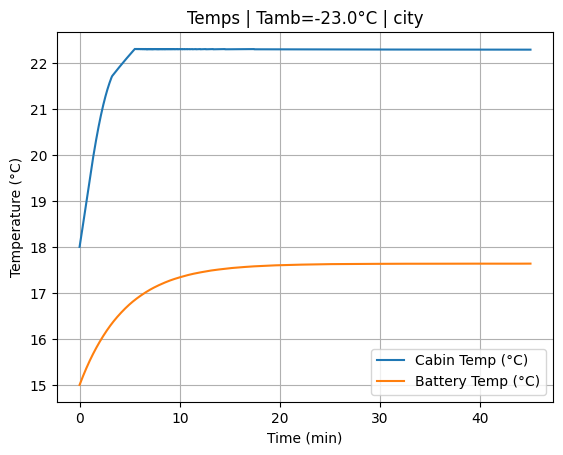

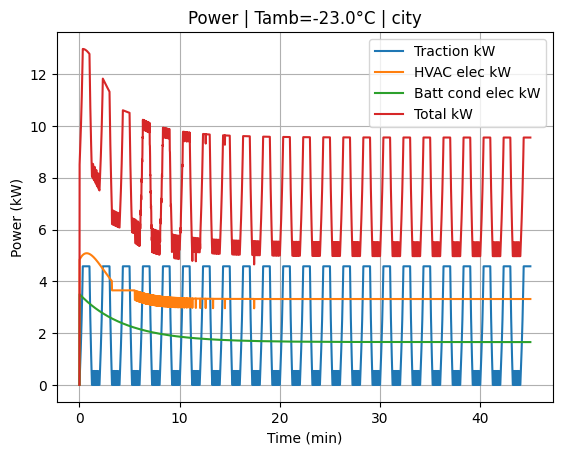

In [8]:
def plot_sim(s):
    tt = s["t"]/60
    plt.figure()
    plt.plot(tt, s["T_cabin"], label="Cabin Temp (°C)")
    plt.plot(tt, s["T_batt"], label="Battery Temp (°C)")
    plt.xlabel("Time (min)")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Temps | Tamb={s['Tamb']}°C | {s['drive_case']}")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(tt, s["P_trac"], label="Traction kW")
    plt.plot(tt, np.abs(s["P_hvac"]), label="HVAC elec kW")
    plt.plot(tt, np.abs(s["P_batt"]), label="Batt cond elec kW")
    plt.plot(tt, s["P_total"], label="Total kW")
    plt.xlabel("Time (min)")
    plt.ylabel("Power (kW)")
    plt.title(f"Power | Tamb={s['Tamb']}°C | {s['drive_case']}")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_sim(sims[0])


In [9]:
# Select city cases: cold and hot
cold_city = next(s for s in sims if s["Tamb"] < 0 and s["drive_case"] == "city")
hot_city  = next(s for s in sims if s["Tamb"] > 30 and s["drive_case"] == "city")


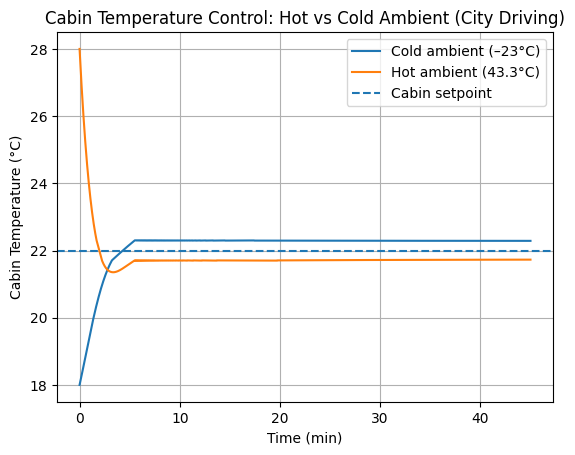

In [10]:
plt.figure()
plt.plot(cold_city["t"]/60, cold_city["T_cabin"], label="Cold ambient (–23°C)")
plt.plot(hot_city["t"]/60,  hot_city["T_cabin"],  label="Hot ambient (43.3°C)")
plt.axhline(T_cabin_set, linestyle="--", label="Cabin setpoint")
plt.xlabel("Time (min)")
plt.ylabel("Cabin Temperature (°C)")
plt.title("Cabin Temperature Control: Hot vs Cold Ambient (City Driving)")
plt.grid(True)
plt.legend()
plt.show()


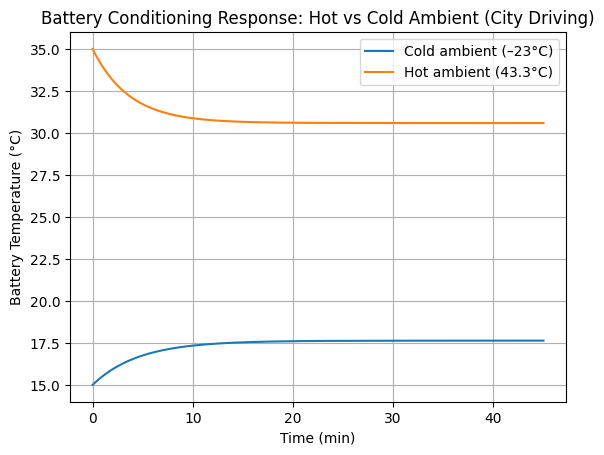

In [11]:
plt.figure()
plt.plot(cold_city["t"]/60, cold_city["T_batt"], label="Cold ambient (–23°C)")
plt.plot(hot_city["t"]/60,  hot_city["T_batt"],  label="Hot ambient (43.3°C)")
plt.xlabel("Time (min)")
plt.ylabel("Battery Temperature (°C)")
plt.title("Battery Conditioning Response: Hot vs Cold Ambient (City Driving)")
plt.grid(True)
plt.legend()
plt.show()


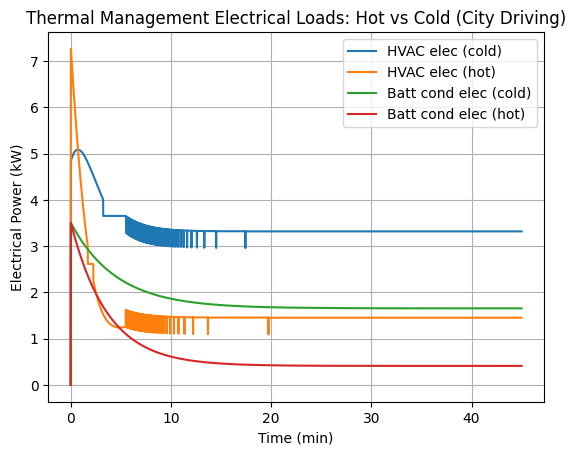

In [12]:
plt.figure()
plt.plot(cold_city["t"]/60, np.abs(cold_city["P_hvac"]), label="HVAC elec (cold)")
plt.plot(hot_city["t"]/60,  np.abs(hot_city["P_hvac"]),  label="HVAC elec (hot)")
plt.plot(cold_city["t"]/60, np.abs(cold_city["P_batt"]), label="Batt cond elec (cold)")
plt.plot(hot_city["t"]/60,  np.abs(hot_city["P_batt"]),  label="Batt cond elec (hot)")
plt.xlabel("Time (min)")
plt.ylabel("Electrical Power (kW)")
plt.title("Thermal Management Electrical Loads: Hot vs Cold (City Driving)")
plt.grid(True)
plt.legend()
plt.show()


## Interpretation

- In cold ambient, HVAC heating demand can dominate energy, especially in city driving where traction energy per minute is lower.
- Battery conditioning adds energy cost but helps control battery temperature toward a usable operating range.
- In hot ambient, cabin cooling and battery cooling can both contribute, and sustained highway loads can increase battery heat generation.

This model is intentionally simplified but demonstrates closed-loop thermal management trade-offs.
